<a href="https://colab.research.google.com/github/HarisudhanVL/Python-Projects/blob/main/Ticket%20Dispensation%20-%20III/Multiple_face_detection_clssification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Required Libraries.**

In [ ]:
import cv2
import imutils
import pathlib
import numpy as np
import tensorflow as tf
from base64 import b64decode
import matplotlib.pyplot as plt
from IPython.display import Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript

**Start Web camera.**

In [99]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

**Capture the image through web camera - click the capture button.**

By clicking the capture button image is captured and saved locally.

<IPython.core.display.Javascript object>

Saved to photo.jpg


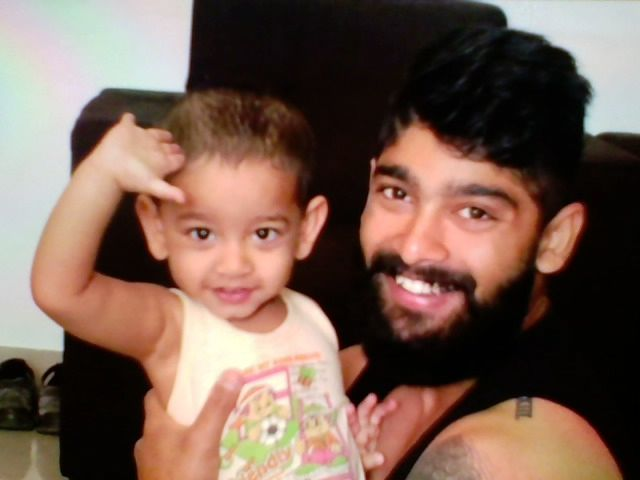

In [100]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**Read the saved captured image.**

In [101]:
image = cv2.imread(filename)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]

**Convert captured image from BGR to gray scale.**

In [102]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

**Face detection using Haar Cascade Classifier.**

In [103]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

**Number of faces detected in the captured image.**

In [104]:
print("[INFO] Found {0} Faces!".format(len(faces)))

[INFO] Found 2 Faces!


**Detected faces in the captured image.**

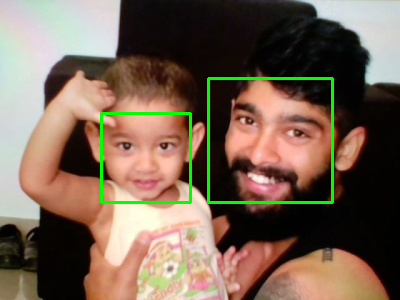

In [105]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2_imshow(image)
    

**Extract faces from the captured image and save it loacally in the drive.**

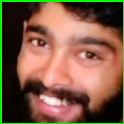

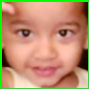

In [106]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_color = image[y:y + h, x:x + w]
    cv2_imshow(roi_color)
    cv2.imwrite('/content/drive/MyDrive/data set/Multiple_face_capturer/img%s.jpg' % (str(w)+str(h)), roi_color)

**Load the trained MobileNetV2 model.**

In [107]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/data set/model.h5')

**Load the detected images from drive.**

In [108]:
def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))

In [109]:
def image_to_array(image):
    return tf.keras.preprocessing.image.img_to_array(image, dtype=np.int32)

In [110]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [111]:
TEST_IMAGES_DIR_PATH = pathlib.Path('/content/drive/MyDrive/data set/Multiple_face_capturer')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('/content/drive/MyDrive/data set/Multiple_face_capturer/img124124.jpg'),
 PosixPath('/content/drive/MyDrive/data set/Multiple_face_capturer/img8989.jpg')]

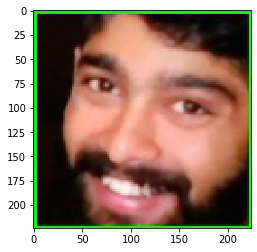

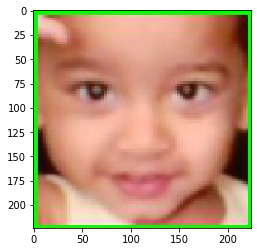

In [112]:
test_images = []
for image_path in TEST_IMAGE_PATHS:
    # <PIL.Image.Image image mode=RGB size=224x224 at 0x141247ED0>
    test_image = load_image(image_path)
    test_image_array = image_to_array(test_image)
    test_images.append(test_image_array)
    display_image(test_image_array)

**Preprocess the extracted faces.**

In [113]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(
        image_array[tf.newaxis, ...]
    )

In [114]:
test_images_preprocessed = []
for test_image in test_images:
    test_image_preprocessed = image_preprocess(test_image)
    test_images_preprocessed.append(test_image_preprocessed)

In [115]:
print('Image shape before preprocessing:', test_images[0].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

Image shape before preprocessing: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)


**Assigning tags(classes) for the extracted images with probability.**

In [116]:
def get_tags(probs, labels, max_classes = 5, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(np.int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [117]:
label = ["0-3", "3-13", "13 and above"]
labels = np.array(label)

**Classifying the extracted images.**

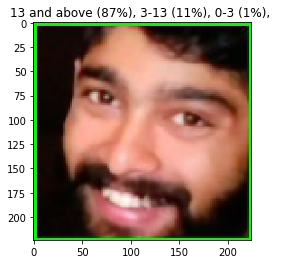

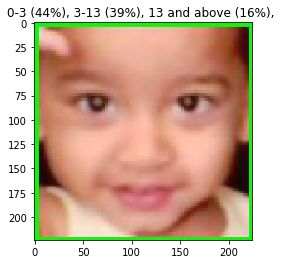

In [118]:
for image_index in range(0, len(test_images)):
    test_image = test_images[image_index]
    test_image_preprocessed = test_images_preprocessed[image_index]
    probabilities = new_model(test_image_preprocessed)
    tags, labels_filtered, probs_filtered = get_tags(probabilities.numpy()[0], labels)
    plt.figure()
    plt.title(tags)
    plt.imshow(test_image);

plt.show()